In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist-train/fashion-mnist_train.csv
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [3]:
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import copy
import pdb
from keras.models import Sequential
from keras import callbacks
import tensorflow as tf
import keras
import sklearn
import tensorflow as tf
from tensorflow.keras import layers, models
%matplotlib inline
sns.set(color_codes=True)
from sklearn.metrics import f1_score
from tensorflow.keras import initializers
from keras.regularizers import l2,l1,l1_l2

2025-05-23 16:03:18.779004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748016199.059167      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748016199.139741      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load the data
data_train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
data_test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

# Prepare data
# Normalization
X_train = data_train.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y_train = to_categorical(data_train['label'].values)

X_test = data_test.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y_test = to_categorical(data_test['label'].values)

In [5]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


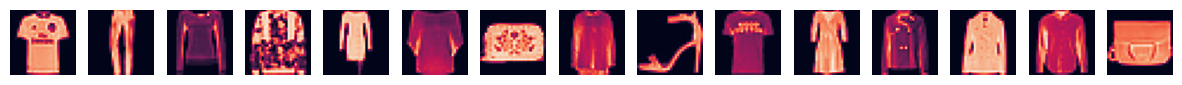

Label [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
plt.show()

print('Label %s' % (y_test[0:5]))

In [6]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
enc.fit(y_train)

y_train_enc = enc.transform(y_train)
y_test_enc = enc.transform(y_test)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

In [7]:
def get_color_and_label(col_name, plot_type):
    if 'val' in col_name:
        color_base = 'r'
        label_base = 'Validation'
    else:
        color_base = 'b'
        label_base = 'Training'

    if plot_type == 'loss':
        if 'loss' in col_name:
            return color_base, label_base
    else:
        if 'loss' not in col_name:
            if 'recall' in col_name:
                return color_base + '--', label_base + ' Recall'
            else:
                return color_base, label_base + ' Precision'
    return None, None

def plot_history(history, plot_type='loss'):
    hist_df = pd.DataFrame(history.history)
    plt.figure(figsize=(20,8))

    for col_name in hist_df.columns:
        color, label = get_color_and_label(col_name, plot_type)
        if color and label:
            plt.plot(hist_df[col_name], color, label=label, lw=4)

    plt.ylabel(plot_type)
    plt.xlabel('Epochs')
    plt.legend(loc="best")
    plt.show()

In [8]:
from keras.layers import Dense, Input, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Flatten
def create_model(hidden_layers: list=['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_1','Flatten','Dense_30'],
                 input_size=X_train.shape[1:], no_classes= y_train_enc.shape[1], activation_func: str='relu',
                 l1_reg: float=0.0, l2_reg: float=0.0,
                 learning_rate: float=0.001, learning_rate_decay: float=0.95,
                 dropout_rate: float=0.0,weight_initializer: str='',
                 optimizer_name: str='adam',regularization_type: str='kernel_regularizer',
                 ):

  # Setup the weight initialization techniques
  if weight_initializer == 'RandomNormal':
    weight_initializer = 'initializers.RandomNormal()'
  elif weight_initializer == 'RandomUniform':
    weight_initializer = 'initializers.RandomUniform()'
  elif weight_initializer == 'Zeros':
    weight_initializer = 'initializers.Zeros()'
  elif weight_initializer == 'GlorotUniform':
    weight_initializer = 'initializers.GlorotUniform()'
  elif weight_initializer == 'GlorotNormal':
    weight_initializer = 'initializers.GlorotNormal()'
  else:
    weight_initializer = 'None'

  model = Sequential()

  model.add(Input(shape=input_size))
  # Add hidden layers
  itr = 0
  for layer in hidden_layers:

      # Determine layer type
      layer_specs = layer.split('_')
      layer_type = layer_specs[0]
      eval_string = 'model.add('
      if layer_type == 'Dense':
        n_l = layer_specs[1]
        eval_string += 'Dense(%s,' %n_l
      elif layer_type == 'Flatten':
        eval_string += 'Flatten('
      elif layer_type == 'Conv2D':
        kernel_size = layer_specs[1]
        filters = layer_specs[2]
        stride = layer_specs[3]
        if not stride or stride == '0':
          stride = 'None'
        eval_string += 'Conv2D(kernel_size=(%s,%s),strides=%s,filters=%s,' %(kernel_size.split('x')[0],kernel_size.split('x')[1],stride,filters)
      elif 'pool' in layer_type.lower():
        pool_size = layer_specs[1]
        stride = layer_specs[2]
        if not stride or stride == '0':
          stride = 'None'
        eval_string += '%s(pool_size=(%s,%s),strides=%s,' %(layer_type,pool_size.split('x')[0],pool_size.split('x')[1],stride)

      if 'pool' not in layer_type.lower() and 'flatten' not in layer_type.lower():
        eval_string += 'activation="%s",' %activation_func
        eval_string += 'kernel_initializer=%s,' %weight_initializer

        if l1_reg and l2_reg:
          eval_string += '%s=l1_l2(%f,%f),' %(regularization_type,l1_reg,l2_reg)
        elif l1_reg:
          eval_string += '%s=l1(%f),' %(regularization_type,l1_reg)
        elif l2_reg:
          eval_string += '%s=l1(%f),' %(regularization_type,l1_reg)

      eval_string += '))'

      # Add regularization
      if 1:
        eval(eval_string)
      else:
        pdb.set_trace()



      itr += 1

  # Add the last layer's activation layer
  if dropout_rate:
      model.add(Dropout(dropout_rate))
  model.add(Dense(no_classes, activation='softmax'))

  # Next, let's compile it
  if optimizer_name == 'sgd':
    opimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
    opimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'Adadelta':
    opimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate,rho=learning_rate_decay)
  else:
    opimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=learning_rate_decay)
  model.compile(
        loss='categorical_crossentropy',
        optimizer=opimizer,
        metrics=['accuracy'],
        )

  return model

In [9]:
model = create_model(activation_func='sigmoid', l1_reg=0, l2_reg=0)
model.summary()

2025-05-23 16:03:48.302894: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 20)            │           5,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 8, 8, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │          38,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,860 (171.33 KB)

 Trainable params: 43,860 (171.33 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
train_params = {
    'x': X_train,
    'y': y_train_enc,
    'batch_size': 16,
    'epochs': 15,
    'validation_split': 0.2,
    'callbacks': [early_stopping]
}

# Train the model
history = model.fit(**train_params)

Epoch 1/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.4927 - loss: 1.4274 - val_accuracy: 0.7352 - val_loss: 0.6824
Epoch 2/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.7579 - loss: 0.6254 - val_accuracy: 0.7844 - val_loss: 0.5633
Epoch 3/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8079 - loss: 0.5136 - val_accuracy: 0.8302 - val_loss: 0.4684
Epoch 4/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8339 - loss: 0.4476 - val_accuracy: 0.8403 - val_loss: 0.4250
Epoch 5/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8525 - loss: 0.4026 - val_accuracy: 0.8443 - val_loss: 0.4198
Epoch 6/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8634 - loss: 0.3766 - val_accuracy: 0.8666 - val_loss: 0.3709
Epoch 7/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8700 - loss: 0.3500 - val_accuracy: 0.8648 - val_loss: 0.3579
Epoch 8/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8763 - loss: 0

In [11]:
def plot_history(history,plot_type: str='loss'):
  hist_df = pd.DataFrame(history.history)
  plt.figure(figsize=(20,10))
  colors = []
  columns_to_plot = []
  labels = []
  for col_name in hist_df.columns:

    if 'val' in col_name:
      validation = True
      color_base = 'r'
      label_base = 'Validation'
    else:
      validation = False
      color_base = 'b'
      label_base = 'Training'

    if plot_type == 'loss':
      if 'loss' in col_name:
        labels.append(label_base)
        columns_to_plot.append(col_name)
        colors.append(color_base)
    else:
      if 'loss' in col_name:
        continue
      if 'recall' in col_name:
        color = color_base + '--'
        label = label_base + 'Recall'
      else:
        color = color_base
        label = label_base + 'Precision'

      labels.append(label)
      columns_to_plot.append(col_name)
      colors.append(color)



  for itr in range(0,len(columns_to_plot)):
    plt.plot(hist_df.loc[:, [columns_to_plot[itr]]], colors[itr], label=labels[itr],lw=4)

  plt.ylabel(plot_type)
  plt.xlabel('Epochs')
  plt.legend(loc="best")

  plt.show()

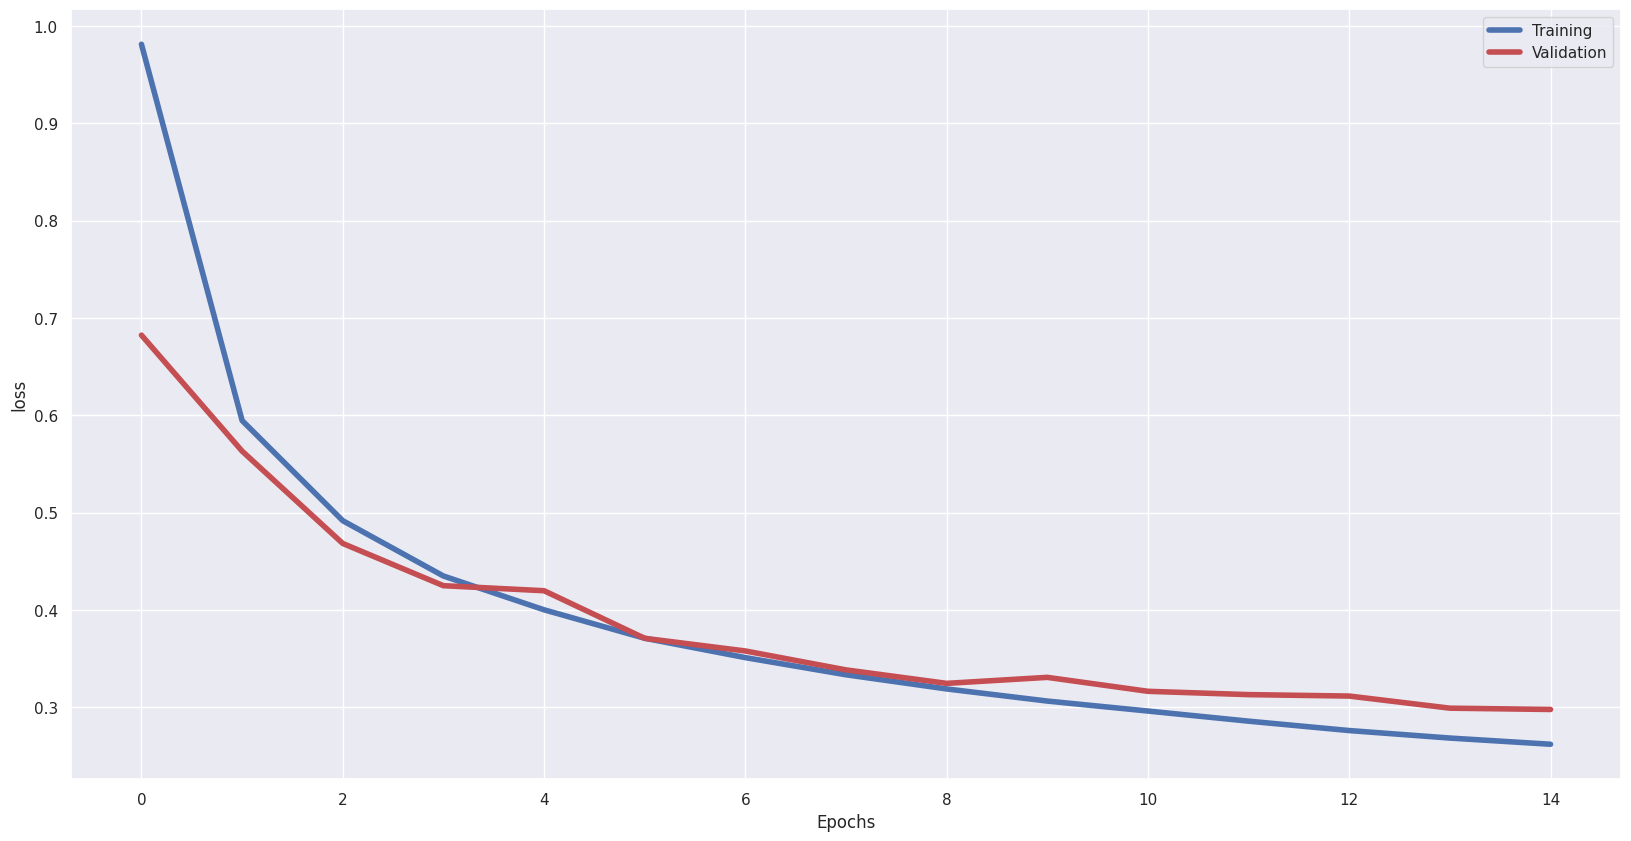

In [12]:
plot_history(history,plot_type='loss')

In [13]:
def convert_predictions(predictions):
    output = np.argmax(predictions, axis=1)
    return output

## K-Fold Cross Validation

In [14]:
from sklearn.model_selection import KFold
def kfold_validation(no_folds: int=3, plot_results: bool=True,
                     model_params: dict={},training_params: dict={}):
  validation_set_accuracy = []
  models = []

  if plot_results:
    verbose=2
  else:
    verbose=0

  itr = 0
  kf = KFold(n_splits=no_folds)
  for train_index, val_index in kf.split(X_train,y_train):
    train_set, y_train_set = X_train[train_index,:,:,:], y_train_enc[train_index]
    val_set,y_val = X_train[val_index,:,:,:], y_train_enc[val_index]

    # First, create a new model
    model = create_model(**model_params)
    #model.summary()

    # Finally, let's fit the model
    history = model.fit(train_set, y_train_set,
                      validation_data=(val_set,y_val),
                      callbacks=[early_stopping],
                      verbose=verbose,
                      **training_params,
                      )


    # Finally, let's
    pred_val = model.predict(val_set)
    f1 = f1_score(convert_predictions(y_val), convert_predictions(pred_val), average='weighted')

    validation_set_accuracy.append(f1)
    models.append(model)

    # Plot the results
    if plot_results:
      plot_history(history,plot_type='acc')


  # Convert to numpy array
  validation_set_accuracy = np.array(validation_set_accuracy)

  # Return the best model (as an example)
  ind = np.argmax(validation_set_accuracy)
  best_model = models[ind]

  # Delete remaining models
  models.remove(best_model)
  for m in models:
    del m

  # Print the reults
  if plot_results:
    print('Average F1-Score over validation set is %.2f' %validation_set_accuracy.mean())
    print('STD of F1-Score over validation set is %.2f' %validation_set_accuracy.std())
  return best_model,validation_set_accuracy.mean(),validation_set_accuracy.std()

In [15]:
def evaluate_efect_param(parameter_type: str='kfold', parameter_name: str='', values_list: list=[]):
    scores_val = []
    scores_test = []
    models = []
    for val in values_list:
        if parameter_type == 'kfold':
            kfold_params[parameter_name] = val
        elif parameter_type == 'model_params':
            kfold_params['model_params'][parameter_name] = val
        elif parameter_type == 'training_params':
            kfold_params['training_params'][parameter_name] = val

        model, validation_set_accuracy_mean, validation_set_accuracy_std = kfold_validation(**kfold_params)

        scores_val.append(validation_set_accuracy_mean)

        predictions = model.predict(X_test)
        score_test = f1_score(convert_predictions(y_test_enc), convert_predictions(predictions), average='weighted')
        scores_test.append(score_test)

        models.append(model)
        print('Val: %s, Validation Score: %.3f, Test Score: %.3f' % (str(val), validation_set_accuracy_mean, score_test))

    # Plot the results
    plt.figure(figsize=(20, 8))
    str_values_list = []
    for v in values_list:
        str_values_list.append(str(v))

    plt.plot(str_values_list, scores_test, lw=5)
    plt.plot(str_values_list, scores_val, lw=5, color='orange')
    plt.xlabel(parameter_name)
    plt.ylabel('F1-Score')
    plt.legend(['F1: Test Set', 'F1: Validation Set'])
    plt.show()

    # Get the best model
    ind = np.argmax(scores_val)
    best_model = models[ind]
    best_val = values_list[np.argmax(scores_val)]

    # Delete remaining models
    models.remove(best_model)
    for m in models:
        del m

    return best_model, best_val

In [16]:
kfold_params = {
    'no_folds': 3,
    'plot_results': False,
    'model_params': {
        'hidden_layers': ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'AveragePooling2D_2x2_1',
                          'Flatten', 'Dense_30'],
        'activation_func': 'relu',
        'l1_reg': 0,
        'l2_reg': 0,
        'learning_rate': 0.001,
        'learning_rate_decay': 0.9,
        'dropout_rate': 0.01,
        'weight_initializer': 'GlorotNormal',
        'optimizer_name': 'adam',
        'regularization_type': 'kernel_regularizer',
    },
    'training_params': {
        'batch_size': 32,
        'epochs': 10
    }
}

In [17]:
model,validation_set_accuracy_mean,validation_set_accuracy_std = kfold_validation(**kfold_params)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


## Tuning learning rate

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.0001, Validation Score: 0.853, Test Score: 0.863
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.001, Validation Score: 0.900, Test Score: 0.906
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.01, Validation Score: 0.876, Test Score: 0.884


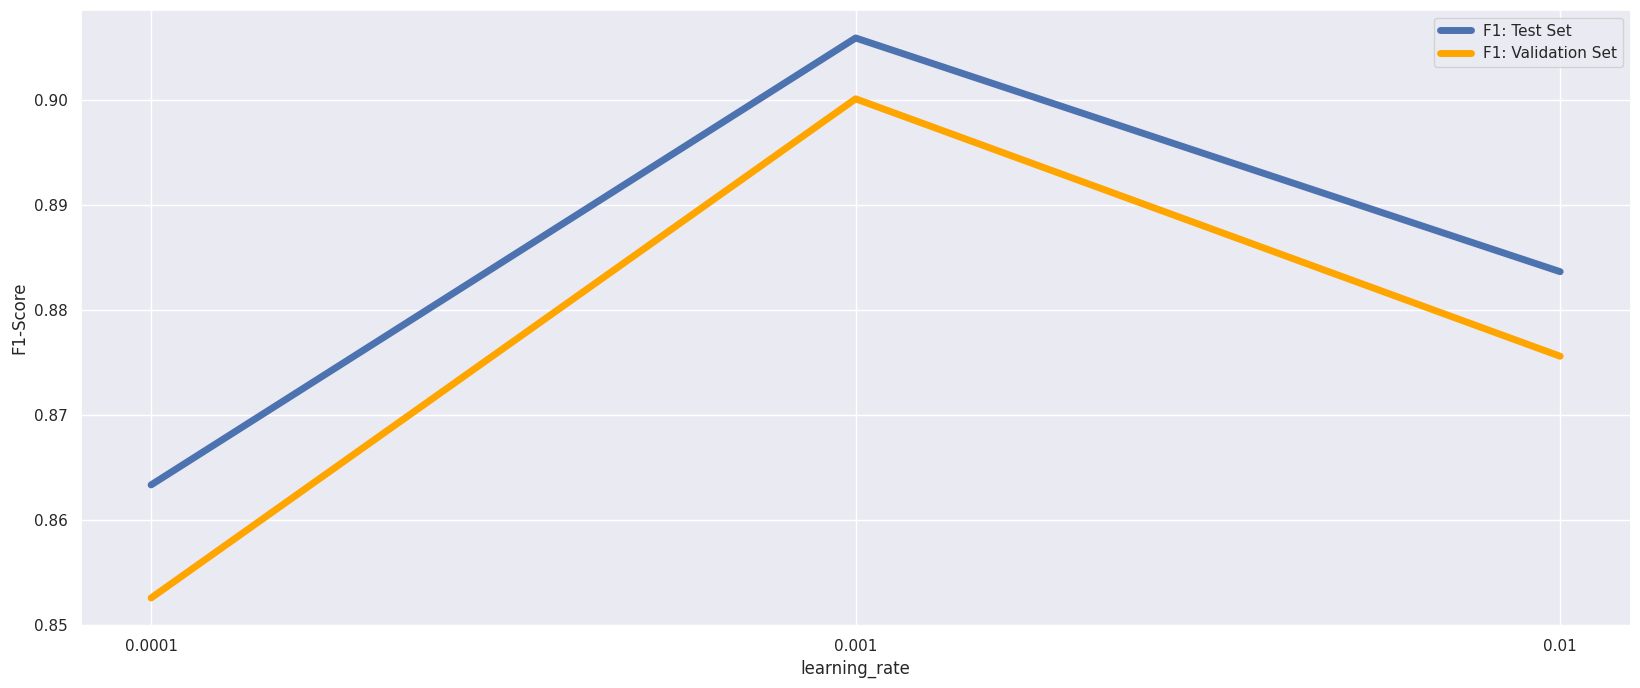

In [29]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'learning_rate',
    'values_list': [0.0001, 0.001, 0.01]
}


model, best_lr = evaluate_efect_param(**eval_params)


kfold_params['model_params']['learning_rate'] = best_lr

## Learning Rate Decay Optimization

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.75, Validation Score: 0.901, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.85, Validation Score: 0.905, Test Score: 0.910
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.95, Validation Score: 0.903, Test Score: 0.911


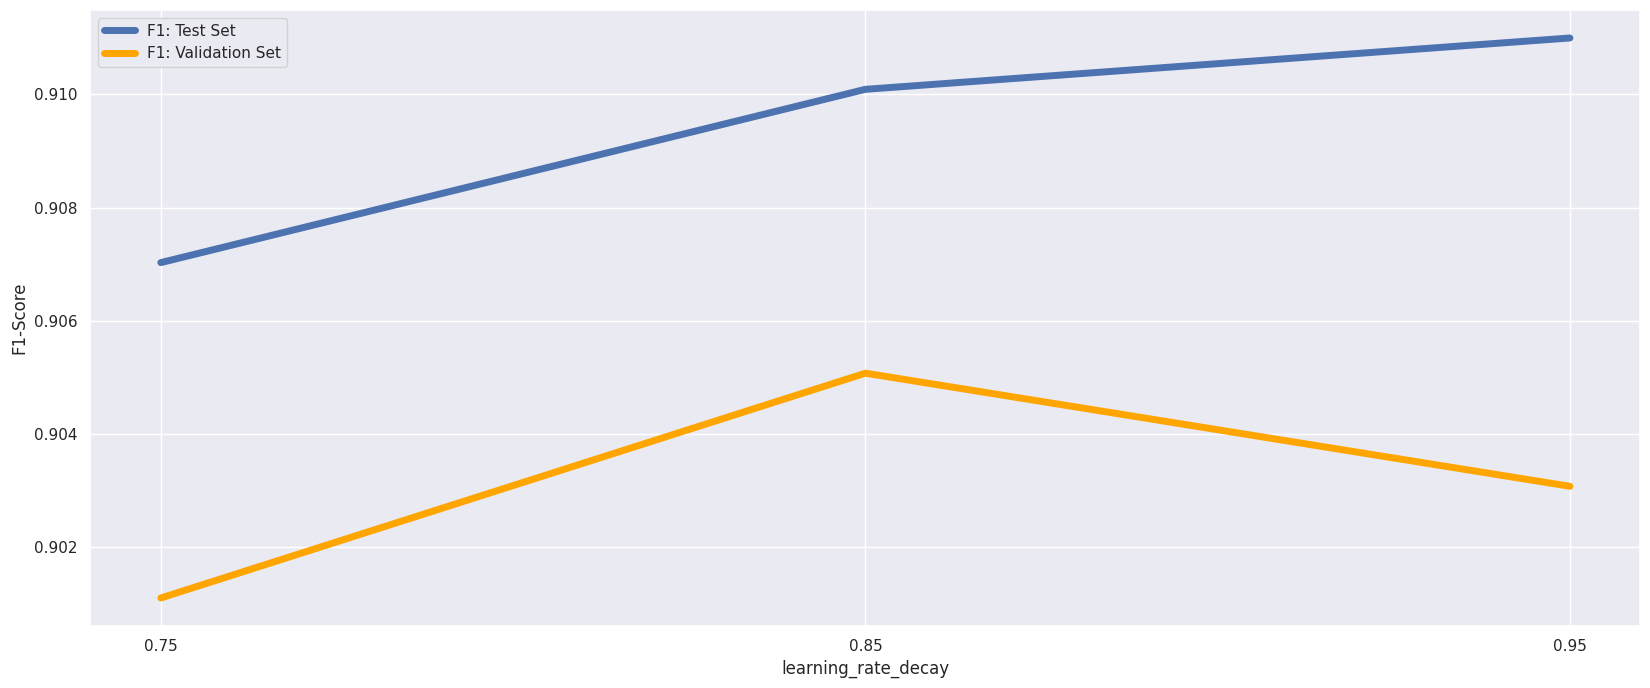

In [30]:
model,best_lr_decay = evaluate_efect_param(parameter_type='model_params',parameter_name='learning_rate_decay', values_list=[0.75,0.85,0.95])
kfold_params['model_params']['learning_rate_decay'] = best_lr_decay

## Tuning Optimizer

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: sgd, Validation Score: 0.758, Test Score: 0.781
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: adam, Validation Score: 0.902, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: RMSprop, Validation Score: 0.903, Test Score: 0.910
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: Adadelta, Validation Score: 0.340, Test Score: 0.358


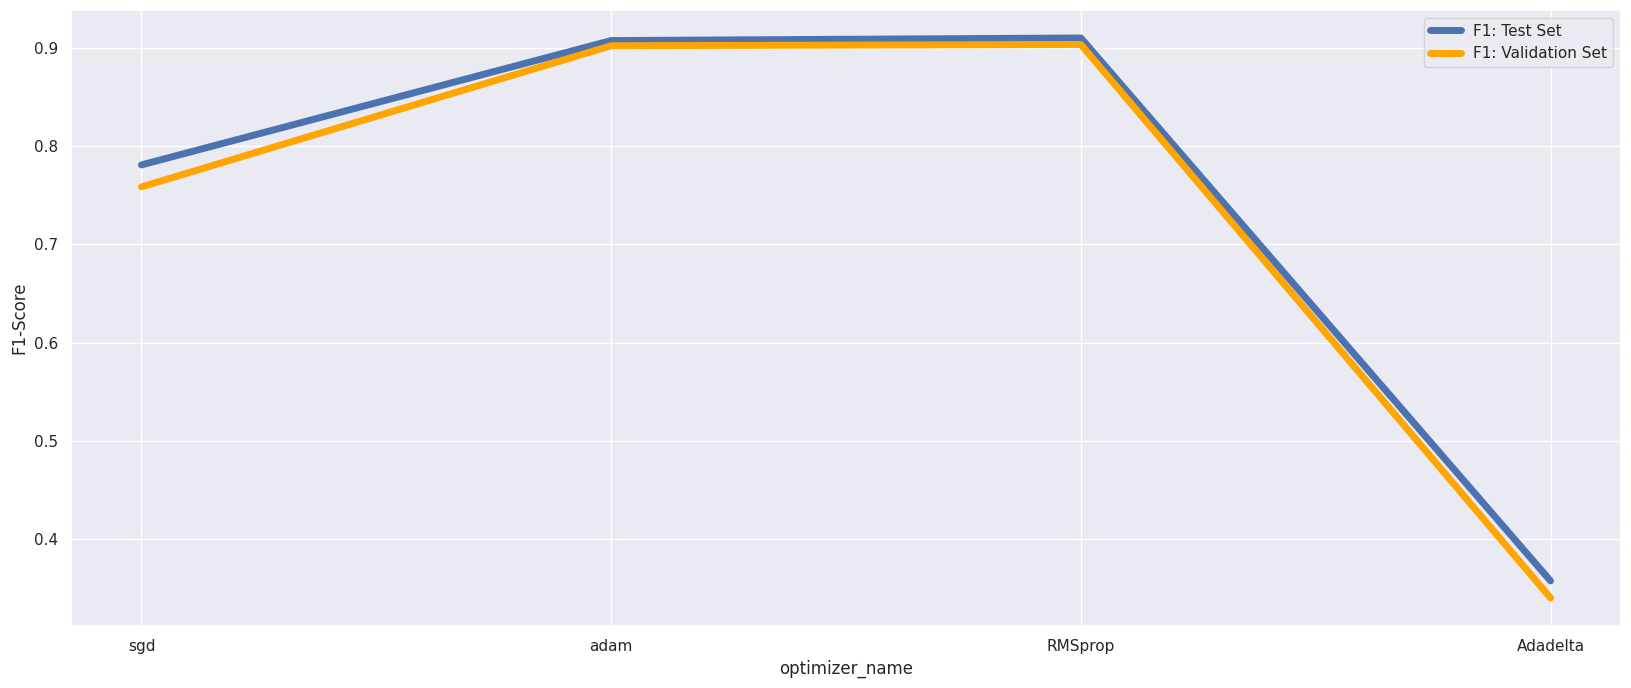

In [31]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'optimizer_name',
    'values_list': ['sgd', 'adam', 'RMSprop', 'Adadelta']
}

model, best_optimizer = evaluate_efect_param(**eval_params)
kfold_params['model_params'].update({'optimizer_name': best_optimizer})

## Tuning activation function

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: relu, Validation Score: 0.904, Test Score: 0.914
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Val: tanh, Validation Score: 0.894, Test Score: 0.896
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Val: sigmoid, Validation Score: 0.858, Test Score: 0.865
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: softplus, Validation Score: 0.876, Test Score: 0.881
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

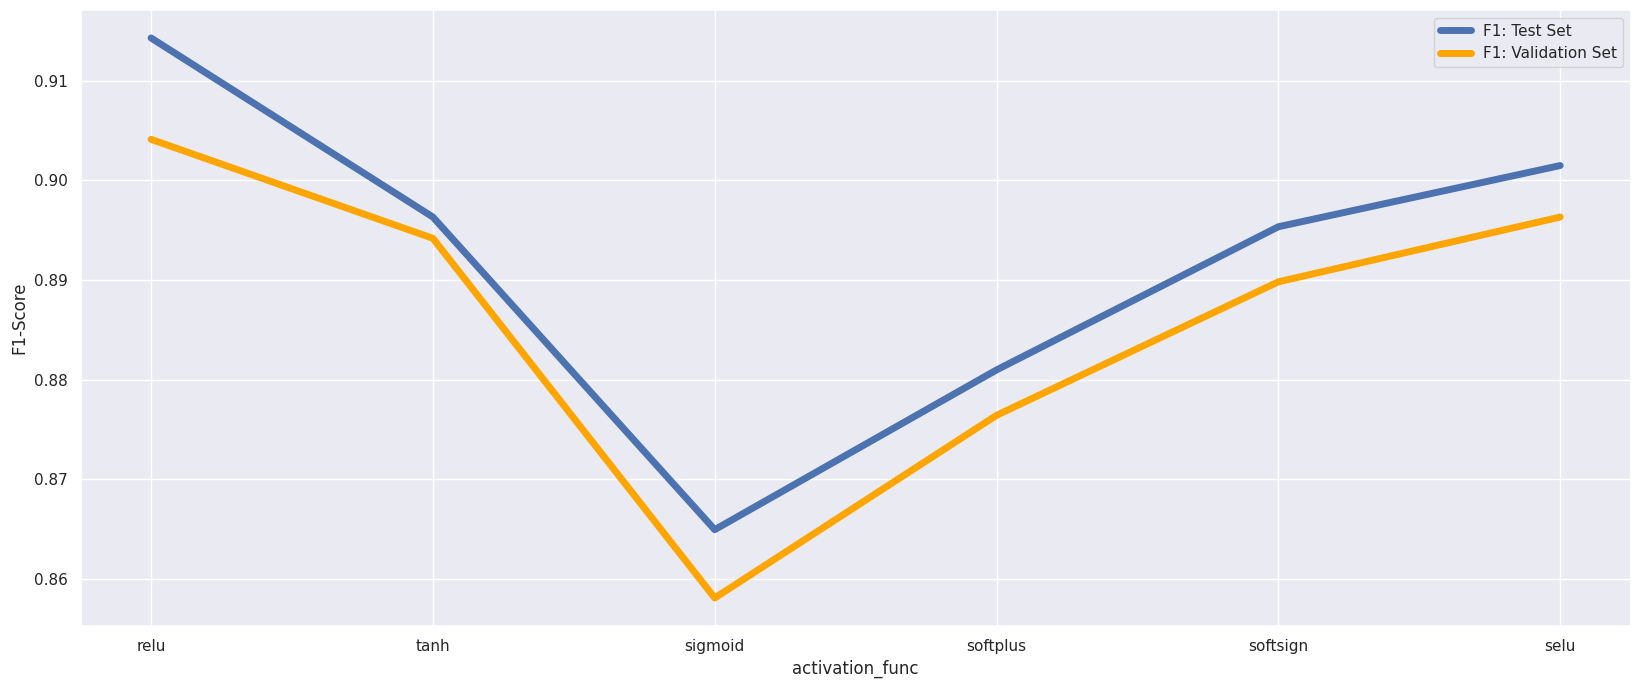

In [32]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'activation_func',
    'values_list': ['relu', 'tanh', 'sigmoid', 'softplus', 'softsign', 'selu']
}

model, best_activation_func = evaluate_efect_param(**eval_params)

kfold_params['model_params'].update({'activation_func': best_activation_func})

## Tuning weight intilizer technique

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: RandomNormal, Validation Score: 0.901, Test Score: 0.906
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: RandomUniform, Validation Score: 0.900, Test Score: 0.903
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: Zeros, Validation Score: 0.017, Test Score: 0.018
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: GlorotUniform, Validation Score: 0.904, Test Score: 0.911
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━

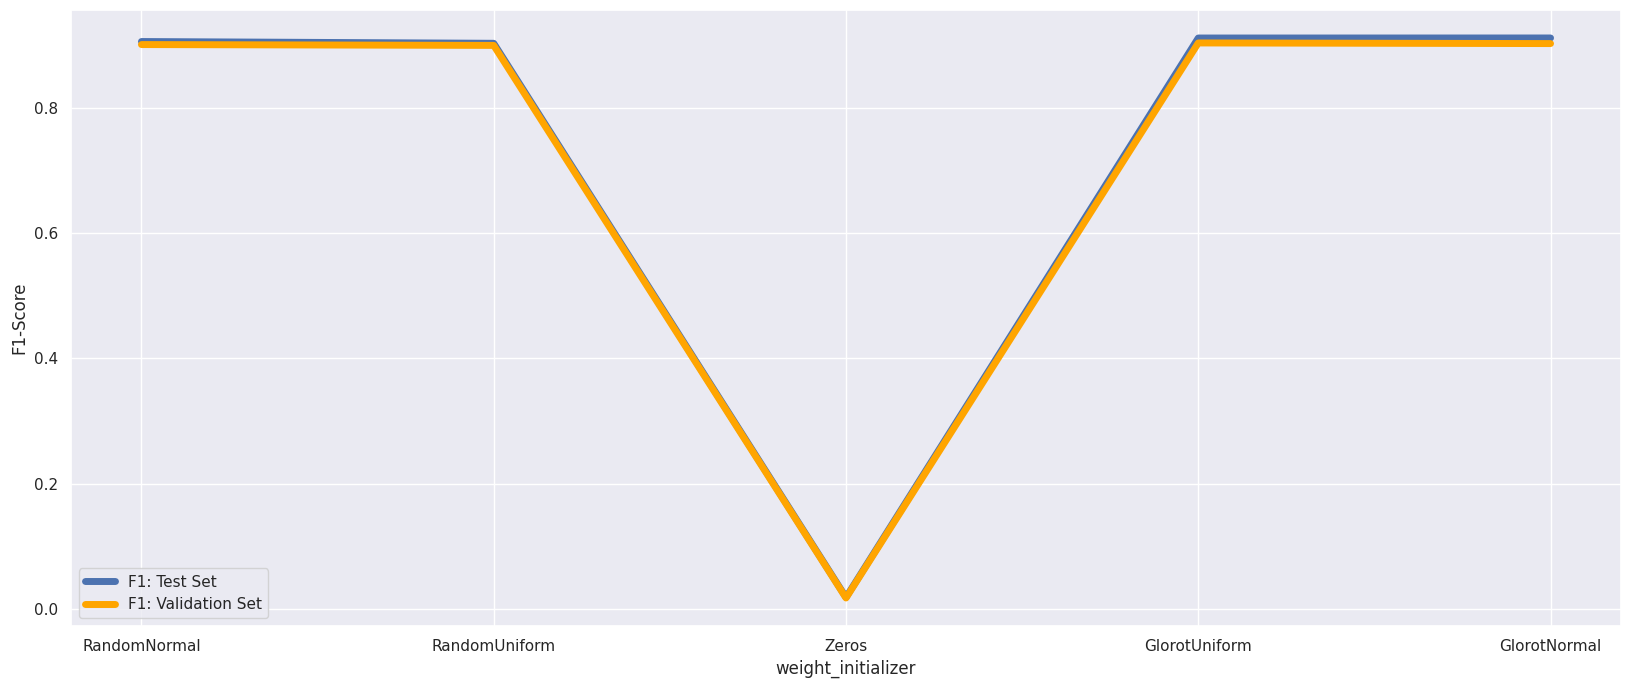

In [33]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'weight_initializer',
    'values_list': ['RandomNormal', 'RandomUniform', 'Zeros', 'GlorotUniform', 'GlorotNormal']
}

model, best_weight_initializer = evaluate_efect_param(**eval_params)
kfold_params['model_params'].update({'weight_initializer': best_weight_initializer})

## Tuning Dropout

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.0001, Validation Score: 0.902, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.01, Validation Score: 0.904, Test Score: 0.908
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.1, Validation Score: 0.902, Test Score: 0.906


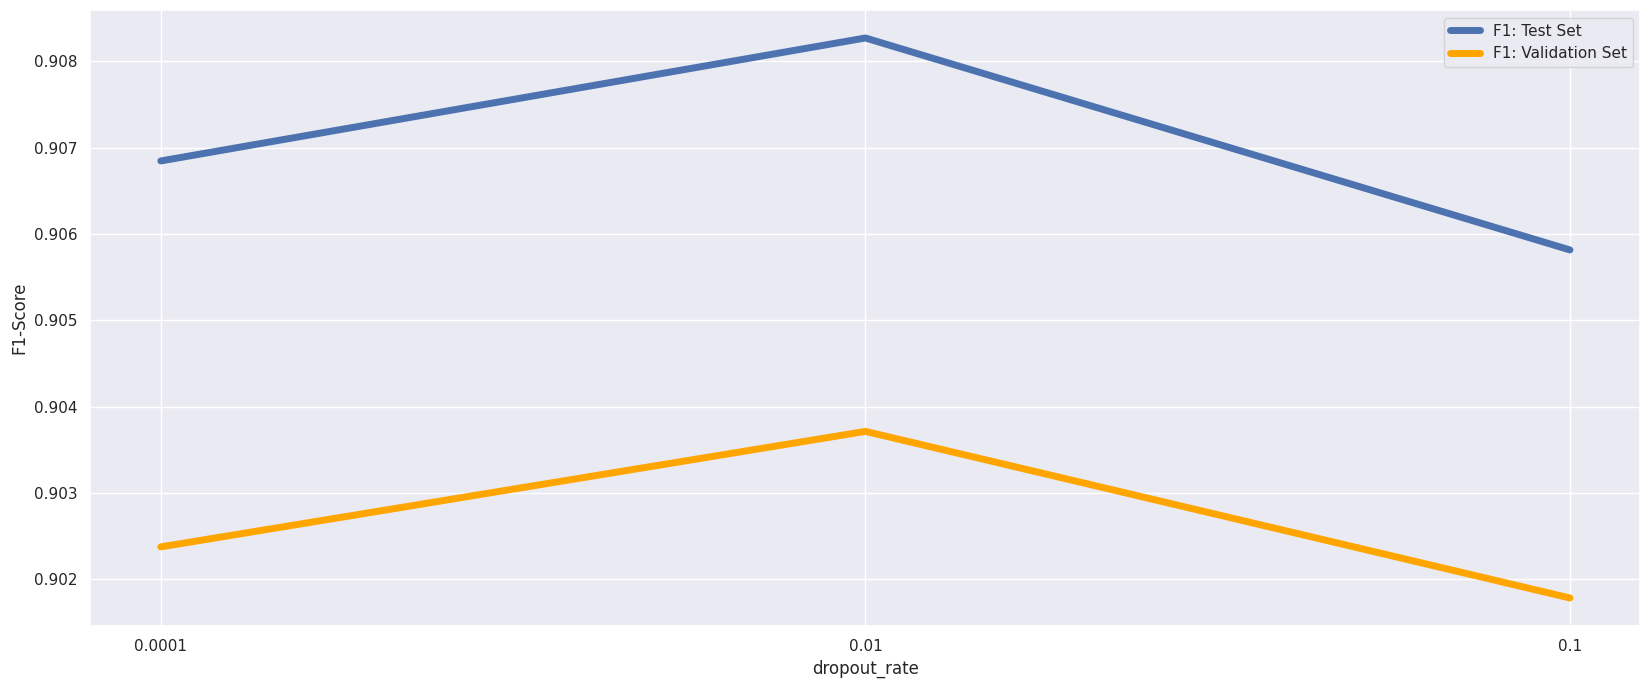

In [34]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'dropout_rate',
    'values_list': [0.0001, 0.01, 0.1]
}
model, best_dropout_rate = evaluate_efect_param(**eval_params)
kfold_params['model_params'].update({'dropout_rate': best_dropout_rate})

## Tuning L1-l2 Regularization

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 1e-05, Validation Score: 0.903, Test Score: 0.904
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.0001, Validation Score: 0.893, Test Score: 0.899
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.001, Validation Score: 0.849, Test Score: 0.860


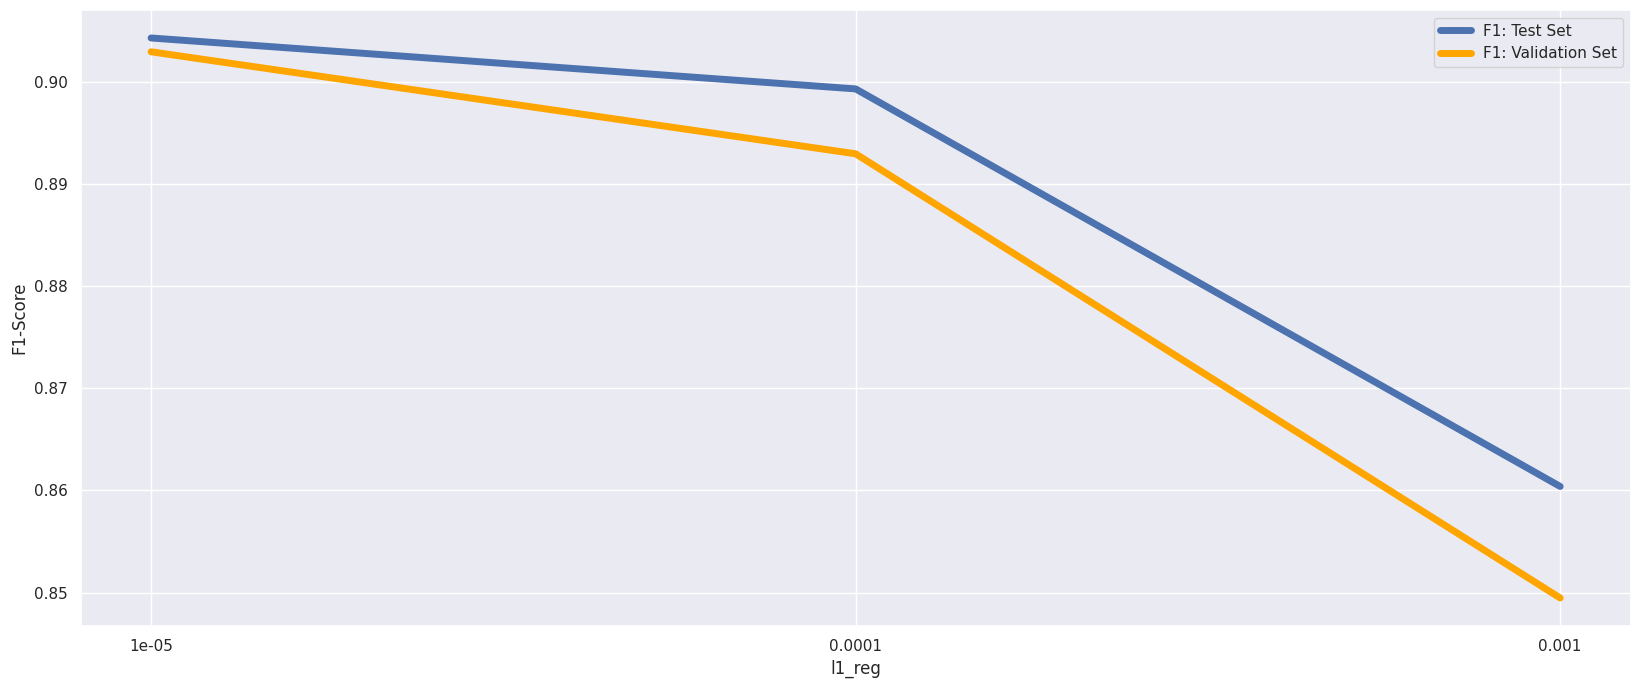

In [35]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'l1_reg',
    'values_list': [0.00001, 0.0001, 0.001]
}

model, best_l1_reg = evaluate_efect_param(**eval_params)


kfold_params['model_params'].update({'l1_reg': best_l1_reg})

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 1e-05, Validation Score: 0.900, Test Score: 0.908
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.0001, Validation Score: 0.903, Test Score: 0.908
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Val: 0.001, Validation Score: 0.889, Test Score: 0.894


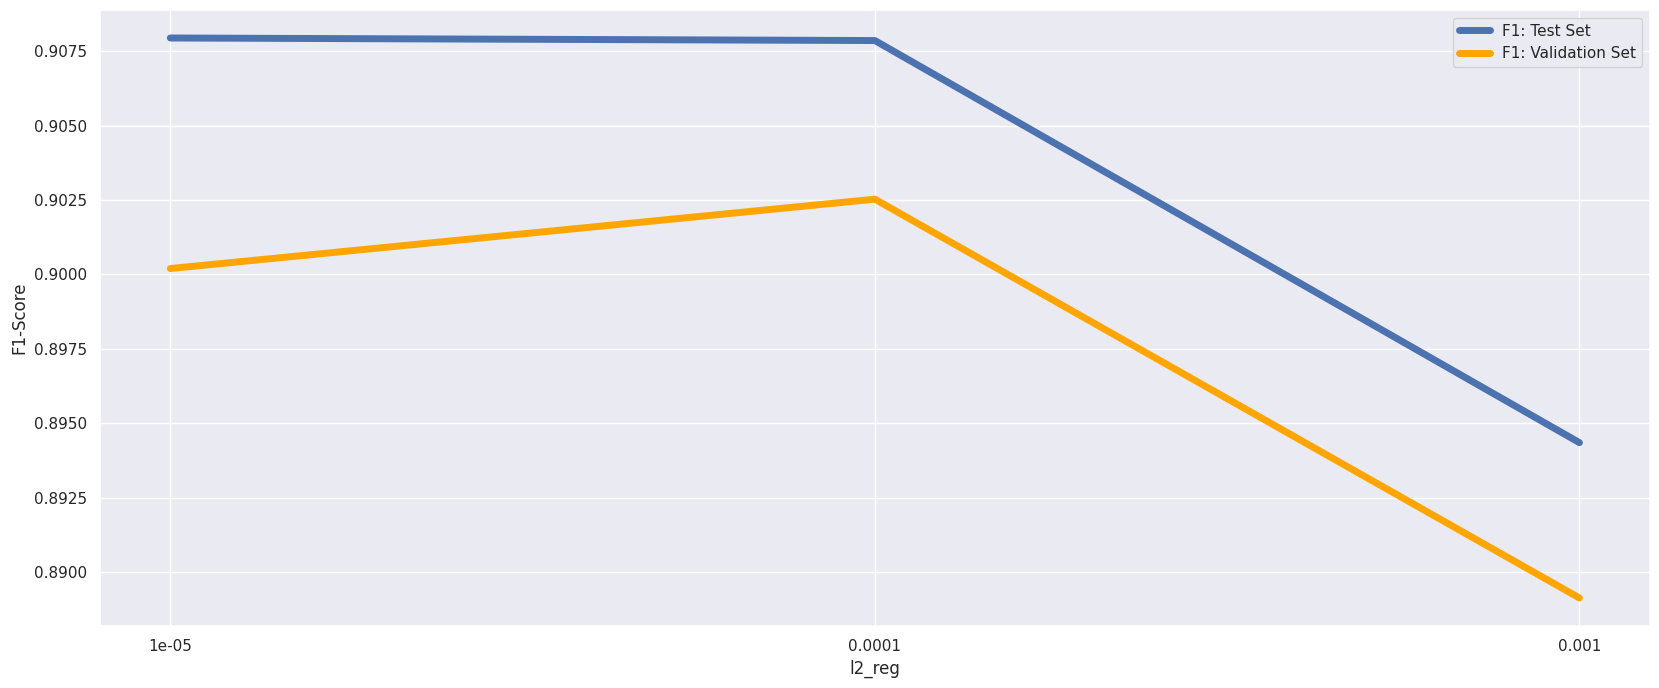

In [36]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'l2_reg',
    'values_list': [0.00001, 0.0001, 0.001]
}

model, best_l2_reg = evaluate_efect_param(**eval_params)

kfold_params['model_params'].update({'l2_reg': best_l2_reg})

## Regularization on activation function

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 1e-05, Validation Score: 0.903, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Val: 0.0001, Validation Score: 0.892, Test Score: 0.900
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.001, Validation Score: 0.017, Test Score: 0.018


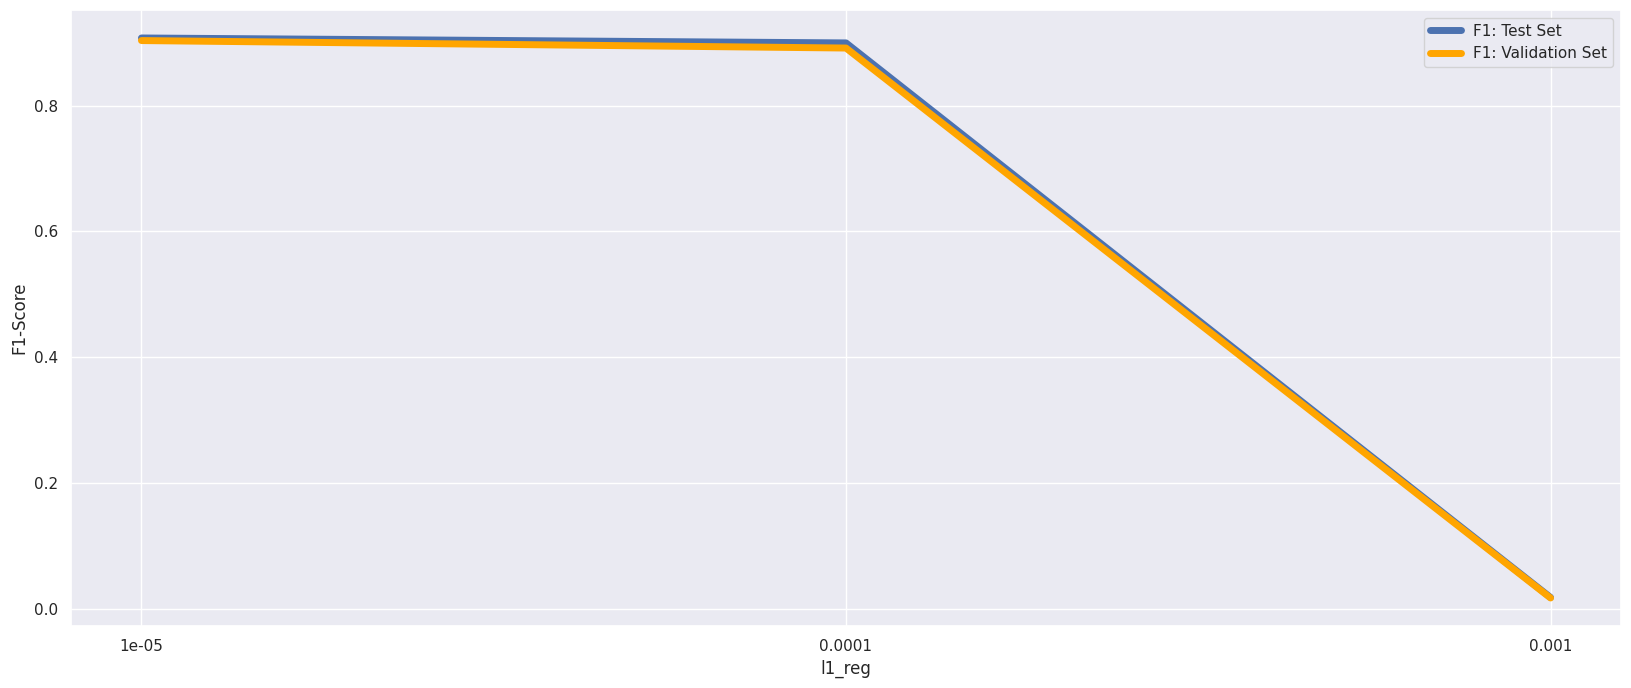

In [37]:
kfold_params['model_params'].update({'regularization_type': 'activity_regularizer'})

eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'l1_reg',
    'values_list': [0.00001, 0.0001, 0.001]
}

model, best_l1_reg = evaluate_efect_param(**eval_params)

kfold_params['model_params'].update({'l1_reg': best_l1_reg})

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 1e-05, Validation Score: 0.903, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Val: 0.0001, Validation Score: 0.902, Test Score: 0.907
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: 0.001, Validation Score: 0.903, Test Score: 0.905


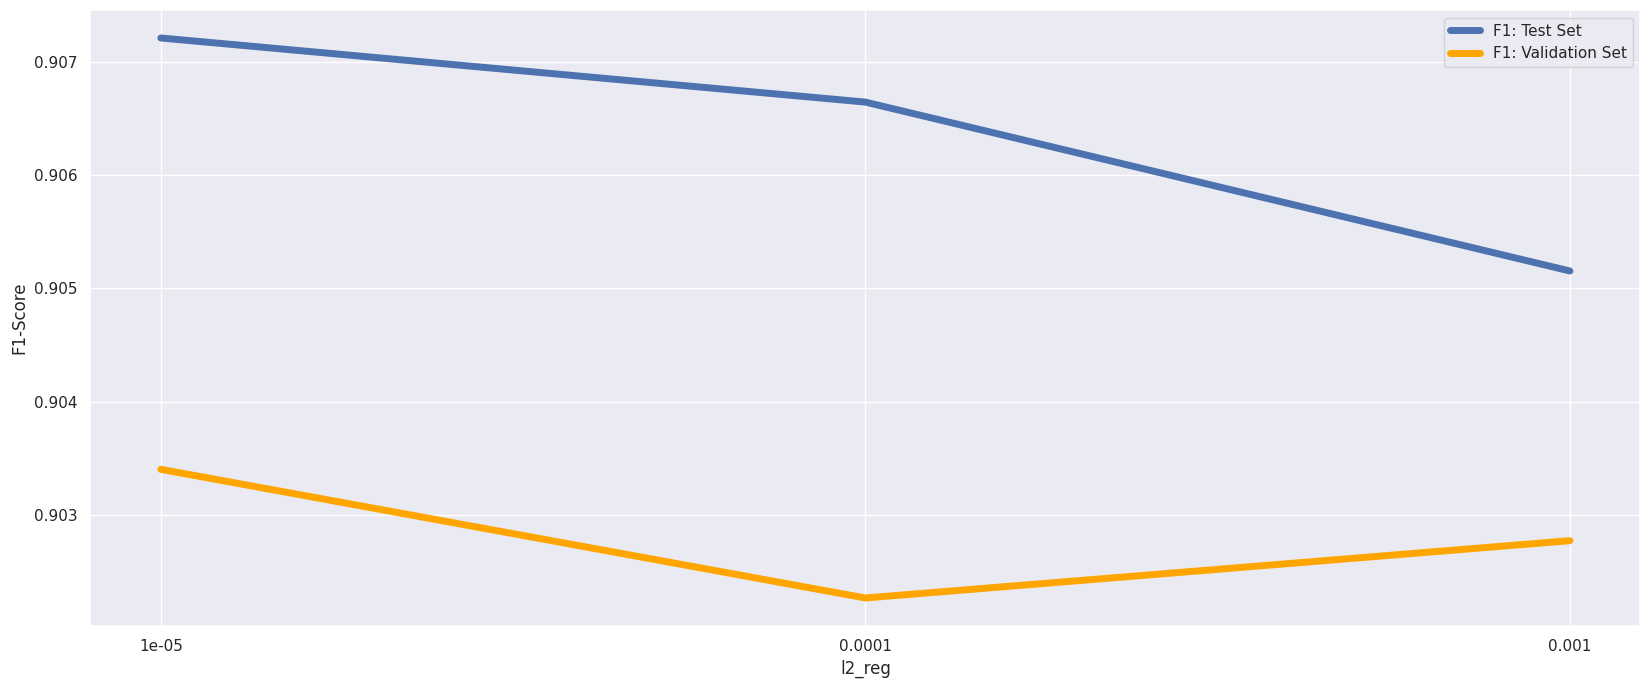

In [18]:
eval_params = {
    'parameter_type': 'model_params',
    'parameter_name': 'l2_reg',
    'values_list': [0.00001, 0.0001, 0.001]
}

# Evaluate the effect of the parameters
model, best_l2_reg = evaluate_efect_param(**eval_params)

# Update the l2 regularization in kfold parameters
kfold_params['model_params'].update({'l2_reg': best_l2_reg})

## Tuning the kernel size for convolutional layers

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_3x3_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_3x3_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.892, Test Score: 0.898
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_5x5_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.895, Test Score: 0.896
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_7x7_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_7x7_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.879, Test Score: 0.883


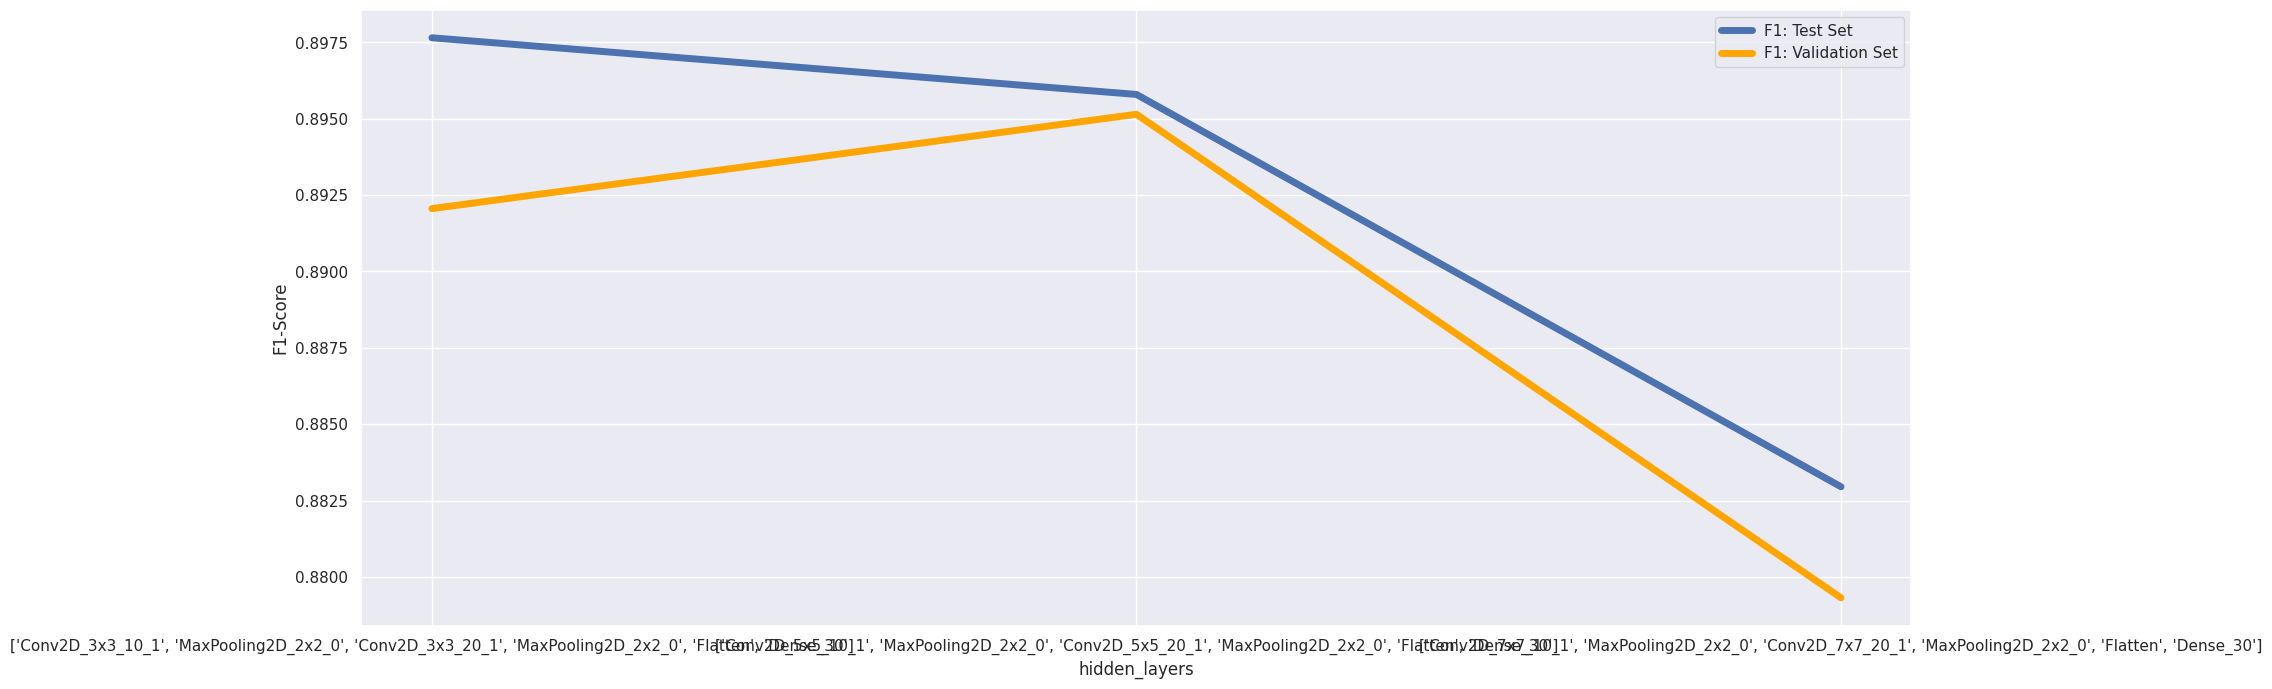

In [19]:
# Kernel size of 3
values_list = [['Conv2D_3x3_10_1','MaxPooling2D_2x2_0','Conv2D_3x3_20_1','MaxPooling2D_2x2_0','Flatten','Dense_30']]


# Kernel size of 5
values_list += [['Conv2D_5x5_10_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','MaxPooling2D_2x2_0','Flatten','Dense_30']]

# Kernel size of 7
values_list += [['Conv2D_7x7_10_1','MaxPooling2D_2x2_0','Conv2D_7x7_20_1','MaxPooling2D_2x2_0','Flatten','Dense_30']]

model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture

## Tuning the stride for convolutional layers

In [20]:
# # Stride 1
values_list = [['Conv2D_5x5_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30']]

# Stride 2 with adjusted pooling parameters
values_list += [['Conv2D_5x5_10_2', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_2', 'MaxPooling2D_2x2_1', 'Flatten', 'Dense_30']]

# Stride 5 with adjusted pooling parameters
values_list += [['Conv2D_5x5_10_5', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_5', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30']]

model, best_architecture = evaluate_efect_param(parameter_type='model_params', parameter_name='hidden_layers', values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_5x5_10_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.894, Test Score: 0.895


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_25_1/max_pooling2d_38_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 1, 1, 1]](sequential_25_1/conv2d_51_1/Relu)' with input shapes: [32,1,1,20].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(32, 1, 1, 20), dtype=float32)

## Tuning the pooling size for pooling layers

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_5x5_20_1', 'MaxPooling2D_2x2_0', 'Conv2D_5x5_20_1', 'MaxPooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.897, Test Score: 0.903
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val: ['Conv2D_5x5_20_1', 'AveragePooling2D_2x2_0', 'Conv2D_5x5_20_1', 'AveragePooling2D_2x2_0', 'Flatten', 'Dense_30'], Validation Score: 0.895, Test Score: 0.899


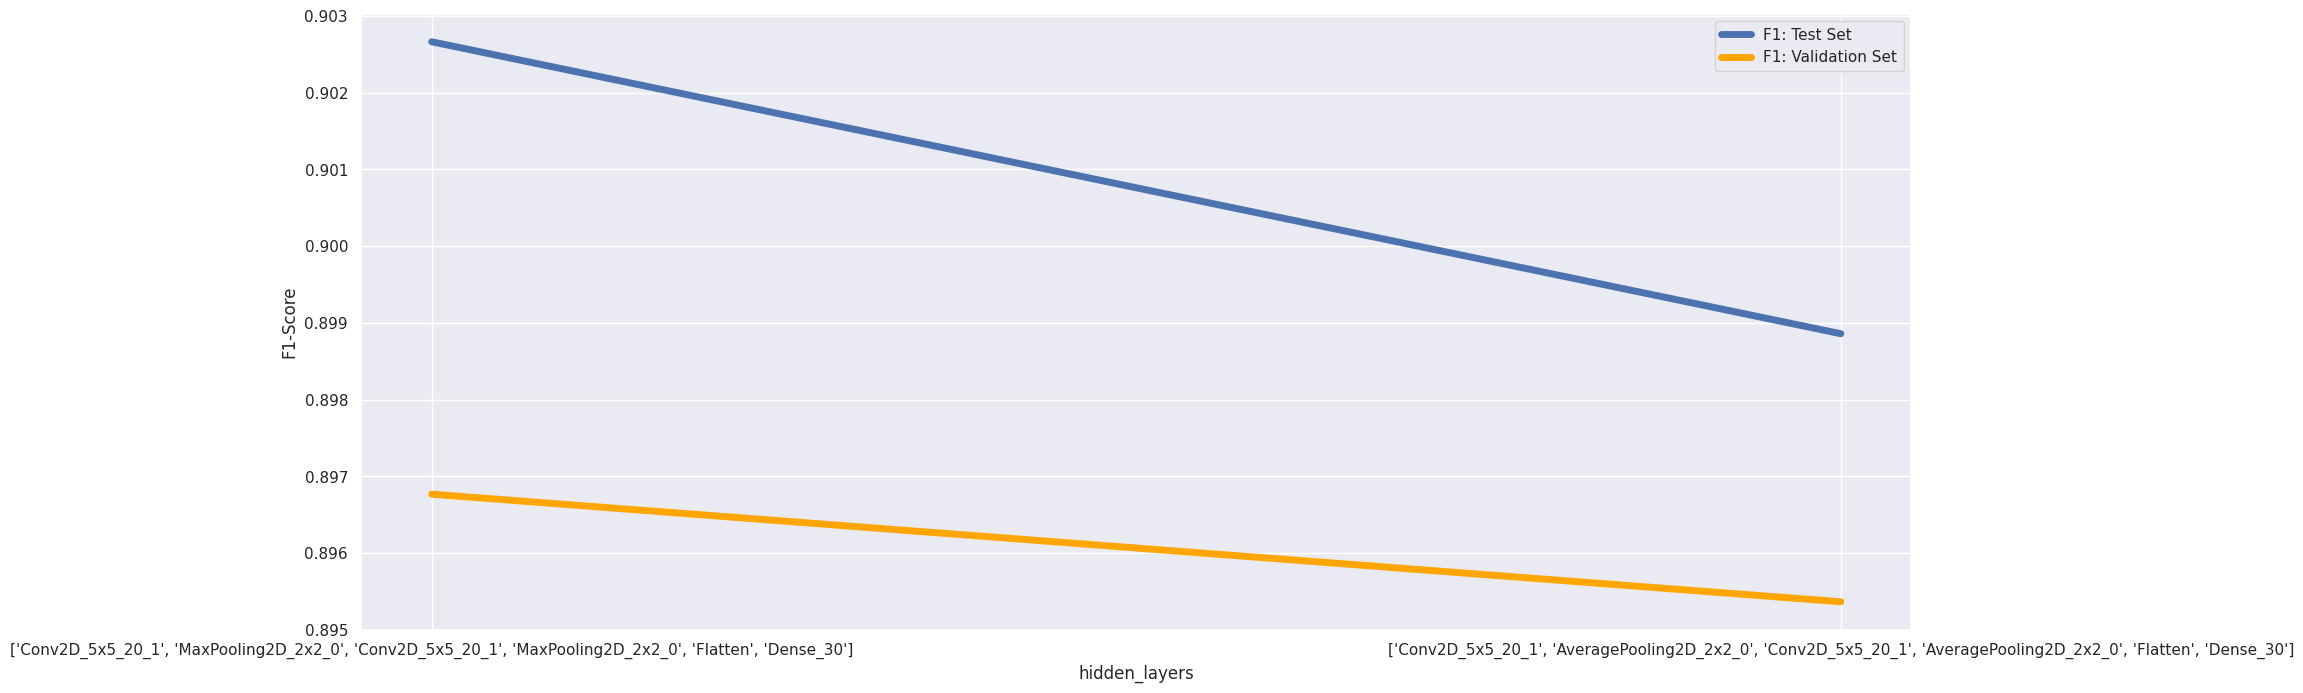

In [21]:
# MaxPooling with stride 0
values_list = [['Conv2D_5x5_20_1','MaxPooling2D_2x2_0','Conv2D_5x5_20_1','MaxPooling2D_2x2_0','Flatten','Dense_30']]

# AveragePooling with stride 0
values_list += [['Conv2D_5x5_20_1','AveragePooling2D_2x2_0','Conv2D_5x5_20_1','AveragePooling2D_2x2_0','Flatten','Dense_30']]


model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='hidden_layers',values_list=values_list)
kfold_params['model_params']['hidden_layers'] = best_architecture

In [22]:
def display_generated_images(image_generator, row_count=6, column_count=6):
    fig, axes = plt.subplots(nrows=row_count, ncols=column_count, figsize=(row_count, column_count))

    for row in range(row_count):
        for col in range(column_count):
            # Get the next image from the generator
            batch = image_generator.next()
            # Convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            # Display the image
            axes[row, col].imshow(image)
            axes[row, col].axis('off')

    plt.show()

In [23]:
x = X_train[1,:,:,:]
x = 255*x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 32,32,3)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#, array_to_img, img_to_array, load_img
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
        validation_split=0.2
        )

In [26]:
train_iterator = train_datagen.flow(X_train, y_train_enc,subset='training',batch_size=32)
val_iterator = train_datagen.flow(X_train, y_train_enc,subset='validation',batch_size=32)

In [28]:
history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    callbacks=[early_stopping],
    steps_per_epoch=len(train_iterator),
    validation_steps=len(val_iterator),
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.5149 - loss: 1.3768 - val_accuracy: 0.6651 - val_loss: 0.9218
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.6772 - loss: 0.8877 - val_accuracy: 0.6908 - val_loss: 0.8204
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.6964 - loss: 0.8224 - val_accuracy: 0.7166 - val_loss: 0.7638
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.7145 - loss: 0.7729 - val_accuracy: 0.7398 - val_loss: 0.7050
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.7256 - loss: 0.7350 - val_accuracy: 0.7377 - val_loss: 0.7065
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.7306 - loss: 0.7308 - val_accuracy: 0.7496 - val_loss: 0.6799
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.7422 - loss: 0.6949 - val_accuracy: 0.7437 - val_loss: 0.6857
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.7490 - loss: 0.68

In [ ]:
plot_history(history,plot_type='loss')
predictions = model.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

## VGG-19 Model

In [ ]:
import numpy as np
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

subset_size = 200

X_train, y_train = X_train[:subset_size], y_train[:subset_size]
X_test, y_test = X_test[:subset_size], y_test[:subset_size]


X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert to 3 channels for VGG19
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Resize images
X_train = np.array([keras.preprocessing.image.img_to_array(keras.preprocessing.image.array_to_img(img).resize((48, 48))) for img in X_train])
X_test = np.array([keras.preprocessing.image.img_to_array(keras.preprocessing.image.array_to_img(img).resize((48, 48))) for img in X_test])

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
y_train_enc = keras.utils.to_categorical(y_train, num_classes=10)
y_test_enc = keras.utils.to_categorical(y_test, num_classes=10)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import VGG19


base_model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(48, 48, 3))

model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(GlobalAveragePooling2D())
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dense(10, activation='softmax'))

# Freeze the base model
base_model_vgg19.trainable = False

# Compile the model
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_vgg19.fit(X_train, y_train_enc, epochs=5, validation_data=(X_test, y_test_enc))

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [32]:
predictions = model_vgg19.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

NameError: name 'model_vgg19' is not defined

## ResNet50

In [ ]:
base_model_resnet50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(48, 48, 3)
)

model_resnet50 = Sequential([
    base_model_resnet50,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

# Freeze the weights of the ResNet50 base model
for layer in base_model_resnet50.layers:
    layer.trainable = False

model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_resnet50.fit(X_train, y_train_enc, epochs=5, validation_data=(X_test, y_test_enc))

In [ ]:
predictions = model_resnet50.predict(X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))